### Introduction

The purpose of this project was to create the basic functionality of a nutrition tracking diary.<br> The nutritional information of foods can visualised in reference to an individual's Recommended Daily Intake (RDI) and added to a daily total.<br>This can be a useful tool for tracking calories, indentifying vitamin and mineral deficiencies or highlighting excessive intake of unhealthy nutrients such as saturated fat and sugar.

__Datasets__<br>
The nutrition datasets used in this project are in the public domain, taken from the U.S Deparment of Agriculture (USDA) available [here](https://fdc.nal.usda.gov/download-datasets.html).

The majority of RDIs were taken from a report by the Institute of Medicine of the National Academies, available [here](https://www.nationalacademies.org/our-work/summary-report-of-the-dietary-reference-intakes). However amino acid RDIs were taken from a World Health Organisation report available [here](https://www.who.int/nutrition/publications/nutrientrequirements/WHO_TRS_935/en/) and
several nutrients not included in those reports such as alcohol and trans fats were taken from the NHS website available [here (alcohol)](https://www.nhs.uk/live-well/alcohol-support/calculating-alcohol-units/) and [here (fats)](https://www.nhs.uk/live-well/eat-well/different-fats-nutrition/)

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [23]:
pd.set_option('max_columns', 300)
pd.set_option('max_rows', 5000)
pd.set_option('display.max_colwidth', None)

In [24]:
#importing necessary CSVs, ignoring mixed dtype warning as specified column will not be used
nutrient_names = pd.read_csv('./New_CSVs/nutrient.csv')
nutrient_values = pd.read_csv('./New_CSVs/food_nutrient.csv')
food_names = pd.read_csv('./New_CSVs/food.csv')

/home/james/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [25]:
print(nutrient_names.shape)
nutrient_names.head(1)

(237, 5)


,id,name,unit_name,nutrient_nbr,rank
0,1002,Nitrogen,G,202.0,500.0


In [26]:
print(nutrient_values.shape)
nutrient_values.head(1)

(7547844, 11)


,id,fdc_id,nutrient_id,amount,data_points,derivation_id,min,max,median,footnote,min_year_acquired
0,13338591,323505,2048,35.0,NaN,49.0,NaN,NaN,NaN,NaN,NaN


In [27]:
print(food_names.shape)
food_names.head(1)

(533612, 5)


,fdc_id,data_type,description,food_category_id,publication_date
0,1105898,experimental_food,Metabolizable Energy of Almonds,NaN,2020-10-30


In [28]:
print(food_names.data_type.unique())

['experimental_food' 'sr_legacy_food' 'sample_food' 'market_acquistion'
 'sub_sample_food' 'foundation_food' 'agricultural_acquisition'
 'branded_food' 'survey_fndds_food']


** For conciseness, a significant portion of messy code has been removed exploring the foods found in each food type and the availability of nutritional info for each, as well as exploring which of the 237 nutrients are most widely available across all the foods. **

<br>

---

<br>

### Data wrangling

Our goal is to create a single dataset containing all the useful foods with correctly labelled nutritional information for each. <br>Several steps must be taken to achieve this: 
- Out of the 533,612 foods, remove any that are not relevant to our application such as experimental foods or repeated samplings of the same foods.
- To avoid an overwhelming amount of information, decide which nutrients are most important to include out the 237 available.
- Join each food with its nutritional information and correctly label the name and unit of each nutrient.

In [29]:
#reducing types of food included (experimental foods with no nutritional info), selecting relevant columns
food_names = food_names.dropna(subset=['description'])
food_names = food_names[food_names.data_type.isin(['branded_food', 'sr_legacy_food', 'survey_fndds_food'])]
food_names = food_names[['fdc_id', 'description']]
food_names.description = food_names.description.str.lower()

In [30]:
#selecting relevant columns, pivoting so each nutrient_id is a column
nutrient_values = nutrient_values.iloc[:, 1:4]
nutrient_values = nutrient_values.pivot(index='fdc_id', columns='nutrient_id', values='amount')

#selecting relevant nutrients with using their nutrient_IDs, removing rows for foods without a description
nutrient_values = nutrient_values[
    [1008,1051,1057,1018,1005,1079,1009,2000,1004,1292,1293,1258,1257,1253,1003,1221,
     1212,1213,1214,1215,1217,1211,1210,1219,1165,1166,1167,1170,1175,1177,1178,1180,
     1104,1162,1110,1109,1185,1087,1098,1100,1089,1090,1101,1091,1092,1103,1093,1095]].reset_index()
nutrient_values.columns.name = None
nutrient_values = nutrient_values[nutrient_values.fdc_id.isin(food_names.fdc_id) == True]

In [31]:
#combining food descriptions with their nutrient values
df = nutrient_values.set_index('fdc_id').join(food_names.set_index('fdc_id')).reset_index()

In [32]:
#using nutrient IDs to select columns of nutrient_names and rename nutrient IDs as their nutrient names with units
nutrient_names = nutrient_names.set_index('id').loc[df.columns[1:-1]]

nutrient_names.loc[[1292, 1293, 1258,1257], 'name'] = ['Monounsaturated fat', 'Polyunsaturated fat', 
                                                       'Saturated fat', 'Trans fat']

name_list = [name.split(',')[0].split('(')[0] + ' ({})'.format(unit.lower()) for 
             name, unit in zip(nutrient_names.name, nutrient_names.unit_name)]

name_list = ['fdc_id'] + name_list + ['Description']
df.columns = name_list

In [33]:
print(df.shape)
df.head(1)

(498824, 50)


,fdc_id,Energy (kcal),Water (g),Caffeine (mg),Alcohol (g),Carbohydrate (g),Fiber (g),Starch (g),Sugars (g),Total lipid (g),Monounsaturated fat (g),Polyunsaturated fat (g),Saturated fat (g),Trans fat (g),Cholesterol (mg),Protein (g),Histidine (g),Isoleucine (g),Leucine (g),Lysine (g),Methionine (g),Phenylalanine (g),Threonine (g),Tryptophan (g),Valine (g),Thiamin (mg),Riboflavin (mg),Niacin (mg),Pantothenic acid (mg),Vitamin B-6 (mg),Folate (ug),Vitamin B-12 (ug),Choline (mg),Vitamin A (iu),Vitamin C (mg),Vitamin D (iu),Vitamin E (mg),Vitamin K (ug),Calcium (mg),Copper (mg),Iodine (ug),Iron (mg),Magnesium (mg),Manganese (mg),Phosphorus (mg),Potassium (mg),Selenium (ug),Sodium (mg),Zinc (mg),Description
0,167512,307.0,35.5,NaN,NaN,41.18,1.2,NaN,5.88,13.24,NaN,NaN,2.941,4.412,0.0,5.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.12,NaN,NaN,NaN,NaN,NaN,1059.0,NaN,"pillsbury golden layer buttermilk biscuits, artificial flavor, refrigerated dough"


<br>

---

<br>

### Recommended Daily Intake (RDI)

Determining the correct nutrient RDIs for an individual is a complex procedure. Factors including age, weight, sex and pregnancy can all change nutrient RDIs significantly. Additionally, different organisations provide different recommendations, all of which change over time.

For simplicity, this project only takes into account weight and sex.

In [34]:
rdi_df = pd.DataFrame(
    columns=['Male', 'Female', 'Colour'],
    index=df.columns[1:-1],
    data=[[2500, 2000, '#C26862'],
         [3700, 2700, '#589A5D'],
         [400, 400, '#C26862'],
         [16, 16, '#C26862'],
         [130, 130, '#589A5D'],
         [38, 25, '#589A5D'],
         [np.nan, np.nan, 'white'],
         [30, 30, '#C26862'],
         [70, 70, '#C26862'],
         [np.nan, np.nan, 'white'],
         [np.nan, np.nan, 'white'],
         [20, 20, '#C26862'],
         [5, 5, '#C26862'],
         [300, 300, '#C26862'],
         [0.8, 0.8, '#589A5D'], # protein and all amino acids are per kg bodyweight
         [0.010, 10, '#589A5D'],
         [0.020, 0.020, '#589A5D'],
         [0.039, 0.039, '#589A5D'],
         [0.030, 0.030, '#589A5D'],
         [0.015, 0.015, '#589A5D'],
         [0.025, 0.025, '#589A5D'],
         [0.015, 0.015, '#589A5D'],
         [0.004, 0.004, '#589A5D'],
         [0.026, 0.026, '#589A5D'],
         [1.2, 1.1, '#589A5D'],
         [1.3, 1.1, '#589A5D'],
         [16, 14, '#589A5D'],
         [5, 5, '#589A5D'],
         [1.3, 1.3, '#589A5D'],
         [400, 400, '#589A5D'],
         [2.4, 2.4, '#589A5D'],
         [550, 425, '#589A5D'],
         [3000, 2333, '#589A5D'],
         [90, 75, '#589A5D'],
         [800, 800, '#589A5D'],
         [15, 15, '#589A5D'],
         [120, 90, '#589A5D'],
         [1000, 1000, '#589A5D'],
         [0.7, 0.7, '#589A5D'],
         [150, 150, '#589A5D'],
         [8, 18, '#589A5D'],
         [420, 320, '#589A5D'],
         [2.3, 1.8, '#589A5D'],
         [700, 700, '#589A5D'],
         [3400, 2600, '#589A5D'],
         [55, 55, '#589A5D'],
         [1500, 1500, '#C26862'],
         [11, 8, '#589A5D']])

<br>

---

<br>

### Basic regex food search engine

In order the locate the ID for a food we want to visualise, a basic regex search of the food descriptions can be used. Foods containing more nutritional information appear at the top of the search results.

In [35]:
#takes in keywords to search for food, creates a regex expression which equates to
#"match rows which include this word, and this word..."
print('Please enter a food:')
food_input = input().lower()

food_regexed = food_input.split(' ')
for index in range(len(food_regexed)):
    food_regexed[index] = '(?=.*' + food_regexed[index] + '.*)'
food_regexed = "".join(food_regexed)

#calculates the percentage of nutrients available for each food and uses that percentage to orders the results
result = df[df.Description.str.contains(food_regexed, regex=True) == True].copy(deep=True)
result['Completeness (%)'] = result.iloc[:, 1:-1].apply(lambda x: (x.notnull().sum() / 48) * 100, axis=1)
result['Completeness (%)'] = result['Completeness (%)'].round(1)
result = result.sort_values(by='Completeness (%)', ascending=False)
result.iloc[:, -2:]

Please enter a food:
tofu fried


,Description,Completeness (%)
4939,"tofu, fried",95.8
6792,"tofu, fried, prepared with calcium sulfate",83.3
173479,tofu fried rice,33.3
163604,"kibun foods, fried surimi seafood mixed with tofu",29.2
325163,"yellow tofu curry with thai fried rice, medium",29.2
326460,"stir-fried rice noodles with vegetables and tofu in a thai style sauce topped with roasted peanuts noodle bowl, pad thai with tofu",29.2


<br>

---

<br>

### Visualisation

In [36]:
def nutrition_vis(food_df, food_id, grams, rdi_df, advanced_view, sex, weight):
    
    #selecting a food using food_id, unless the input is a Series containing the sum of multiple foods
    if type(food_df) != pd.DataFrame:
        food_series = food_df
        food_name = 'Daily nutrition targets'
    else:
        food_series = food_df.iloc[food_id, 1:-1].astype('Float64').copy(deep=True)
        food_series = (food_series / 100) * grams
        food_name = food_df.iloc[food_id, -1]
    
    #selecting male or female RDI series and applying weight based variations in protein RDI
    rdi_value_series = rdi_df.loc[:, sex].copy(deep=True)
    rdi_value_series.iloc[14:24] = rdi_value_series.iloc[14:24] * weight
    rdi_colour_series = rdi_df.loc[:, 'Colour'].copy(deep=True)
    
    #creating a Series for the food's percentage of RDI 
    rdi_percent_bar = (food_series / rdi_value_series) * 100
    rdi_percent_label = rdi_percent_bar.round(2).astype(str) + '%'
    
    #limiting the bar size to 100% RDI
    rdi_percent_bar = rdi_percent_bar.apply(lambda x: 100. if x > 100 else x)
    
    #formatting the bar when no data or RDI target is available
    for row in range(len(rdi_percent_bar)):
        if np.isnan(food_series[row]) == True:
            rdi_percent_bar[row] = 100
            rdi_percent_label[row] = 'No data'
            rdi_colour_series[row] = '#e5e5e5'
        elif np.isnan(rdi_value_series[row]) == True:
            rdi_percent_bar[row] = 100
            rdi_percent_label[row] = 'No target'
    
    #used to create a simplified nutrition plot or multiple subplots for vitamins, minerals etc.
    def create_plot(ax, food_series, rdi_value_series, rdi_colour_series, rdi_percent_bar, rdi_percent_label):
        
        bars = ax.barh(range(len(food_series)), rdi_percent_bar, color=rdi_colour_series)

        #iterates through each bar's dimensions to determine an appropriate location for the percentage label 
        for bar in range(len(bars)):

            width = bars[bar].get_width()
            width = int(width)

            if width < 40:
                xloc = 6
                align = 'left'
            else:
                xloc = 0
                align = 'center'
                width = width/2

            yloc = bars[bar].get_y() + bars[bar].get_height() / 2

            ax.annotate(
                rdi_percent_label[bar], xy=(width, yloc), xytext=(xloc, 0),
                textcoords="offset points",
                horizontalalignment=align, verticalalignment='center',
                weight='bold', clip_on=True)

        ax.set_yticks(range(len(food_series)))
        ax.set_yticklabels(['{0} - {1} {2}'.format(
            name.split('(')[0].strip(')'), round(value,2), name.split('(')[1].strip(')')) 
            for name, value in zip(food_series.index, food_series)])
        ax.invert_yaxis()
        ax.set_xlim(0,100)
        ax.set_ylim((len(food_series) -0.4), -0.6)
        ax.get_xaxis().set_visible(False)
        
    
    #in a simplified view, nutrients included on nutrition labels are selected and plotted
    if advanced_view == False:
        relevant_nutrients = ['Energy (kcal)', 'Total lipid  (g)', 'Saturated fat (g)', 'Carbohydrate (g)',
                              'Sugars (g)', 'Fiber (g)', 'Protein (g)', 'Sodium (mg)']
        food_series = food_series[relevant_nutrients]
        rdi_value_series = rdi_value_series[relevant_nutrients]
        rdi_colour_series = rdi_colour_series[relevant_nutrients]
        rdi_percent_bar = rdi_percent_bar[relevant_nutrients]
        rdi_percent_label = rdi_percent_label[relevant_nutrients]
        
        fig, ax1 = plt.subplots()
        fig.set_size_inches(13,10)
        
        create_plot(ax1, food_series, rdi_value_series, rdi_colour_series, rdi_percent_bar, rdi_percent_label)
    
    #in an advanced view, all nutrients are plotted, with subplots for each category of nutrient
    else:
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 1],
                                                                                    'height_ratios': [1, 2, 3]})
        fig.set_size_inches(13,20)
        
        ax1.set_title('General')
        create_plot(ax1, food_series[0:4], rdi_value_series[0:4], rdi_colour_series[0:4],
                    rdi_percent_bar[0:4], rdi_percent_label[0:4])
        
        ax2.set_title('Carbohydrates')
        create_plot(ax2, food_series[4:8], rdi_value_series[4:8], rdi_colour_series[4:8],
                    rdi_percent_bar[4:8], rdi_percent_label[4:8])
        
        ax3.set_title('Fats')
        create_plot(ax3, food_series[8:14], rdi_value_series[8:14], rdi_colour_series[8:14],
                    rdi_percent_bar[8:14], rdi_percent_label[8:14])
        
        ax4.set_title('Proteins')
        create_plot(ax4, food_series[14:23], rdi_value_series[14:23], rdi_colour_series[14:23],
                    rdi_percent_bar[14:23], rdi_percent_label[14:23])
        
        ax5.set_title('Vitamins')
        create_plot(ax5, food_series[24:37], rdi_value_series[24:37], rdi_colour_series[24:37],
                    rdi_percent_bar[24:37], rdi_percent_label[24:37])
        
        ax6.set_title('Minerals')
        create_plot(ax6, food_series[37:], rdi_value_series[37:], rdi_colour_series[37:],
                    rdi_percent_bar[37:], rdi_percent_label[37:])
        
    plt.suptitle(food_name.capitalize(), fontweight='bold')
    fig.subplots_adjust(top=0.95, wspace=0.5, hspace=0.07)
    plt.show()

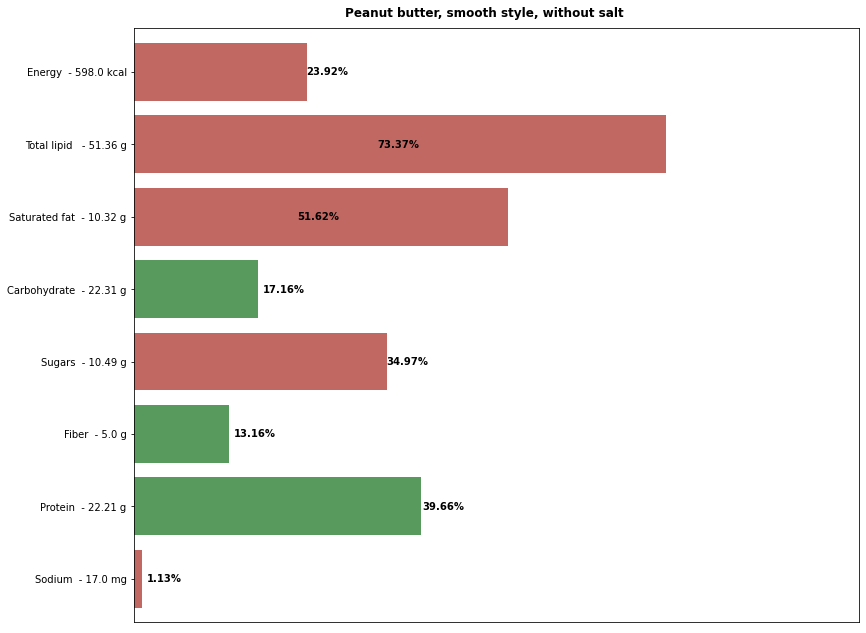

In [37]:
nutrition_vis(df, 4958, 100, rdi_df, False, 'Male', 70)

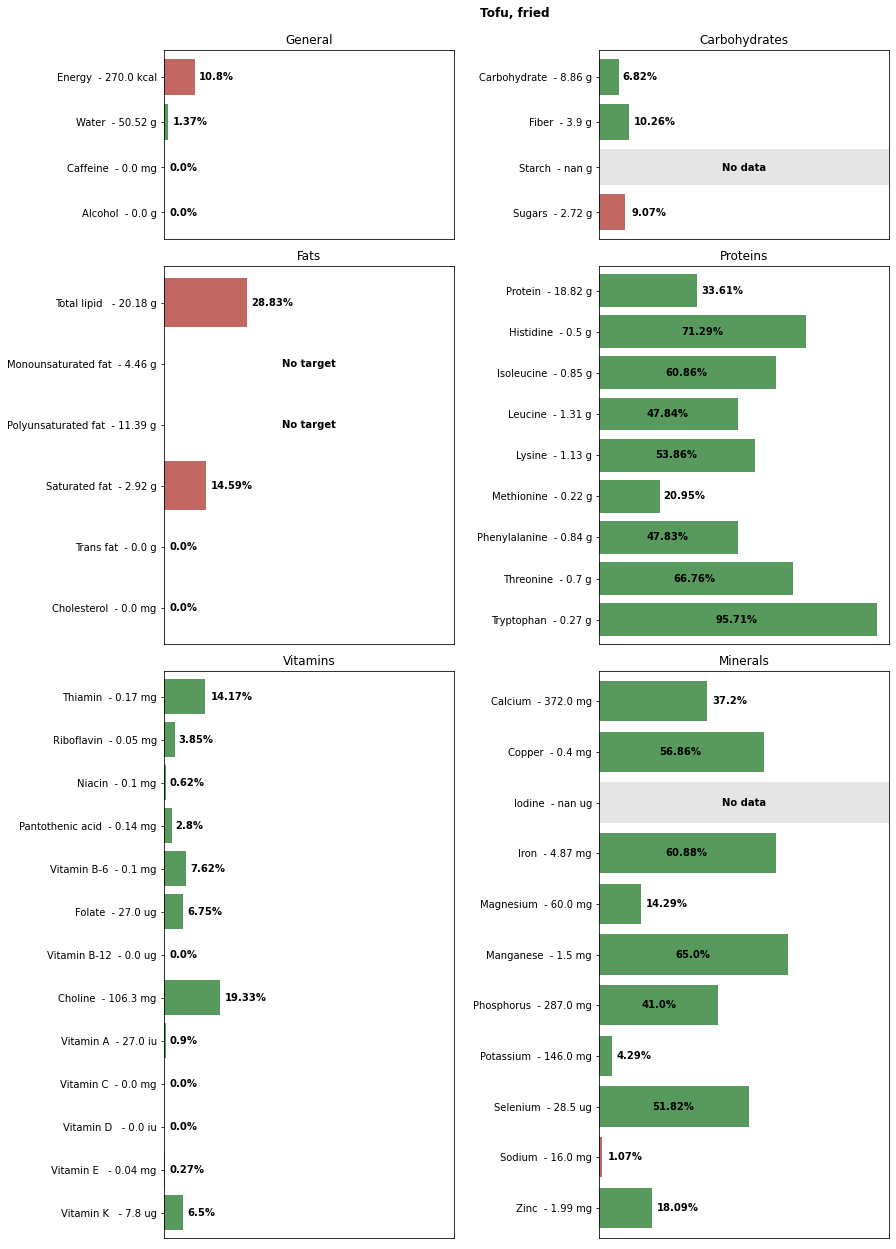

In [38]:
nutrition_vis(df, 4939, 100, rdi_df, True, 'Male', 70)

<br>

---

<br>

## Nutrition diary

In order to track nutrition across the day, multiple foods can summed into a single Series and viewed with the same visualisation function used above

In [39]:
#creating a Series of zeros for each nutrient we would like to track
nutrition_diary = pd.Series(index=df.iloc[1, 1:-1].index, data=np.zeros(48))

#creating a function that returns the sum of our nutrition diary and a specified food
def add_food(nutrition_diary, food_df, food_id, grams):
    nutrition_diary += ((food_df.iloc[food_id, 1:-1].fillna(0) / 100) * grams)
    return nutrition_diary

In [40]:
nutrition_diary = add_food(nutrition_diary, df, 4149, 60) #60g oats
nutrition_diary = add_food(nutrition_diary, df, 7703, 300) #300ml soy milk
nutrition_diary = add_food(nutrition_diary, df, 6432, 120) #120g banana

nutrition_diary = add_food(nutrition_diary, df, 2241, 340) #340g rice 
nutrition_diary = add_food(nutrition_diary, df, 2593, 60) #60g peas
nutrition_diary = add_food(nutrition_diary, df, 5911, 150) #150g egg

nutrition_diary = add_food(nutrition_diary, df, 6180, 140) #140g salmon
nutrition_diary = add_food(nutrition_diary, df, 972, 300) #300g sweet potato
nutrition_diary = add_food(nutrition_diary, df, 878, 100) #100g asparagus

nutrition_diary = add_food(nutrition_diary, df, 1593, 88) #88g orange
nutrition_diary = add_food(nutrition_diary, df, 4176, 100) #100g apple
nutrition_diary = add_food(nutrition_diary, df, 6782, 60) #60g peanut butter

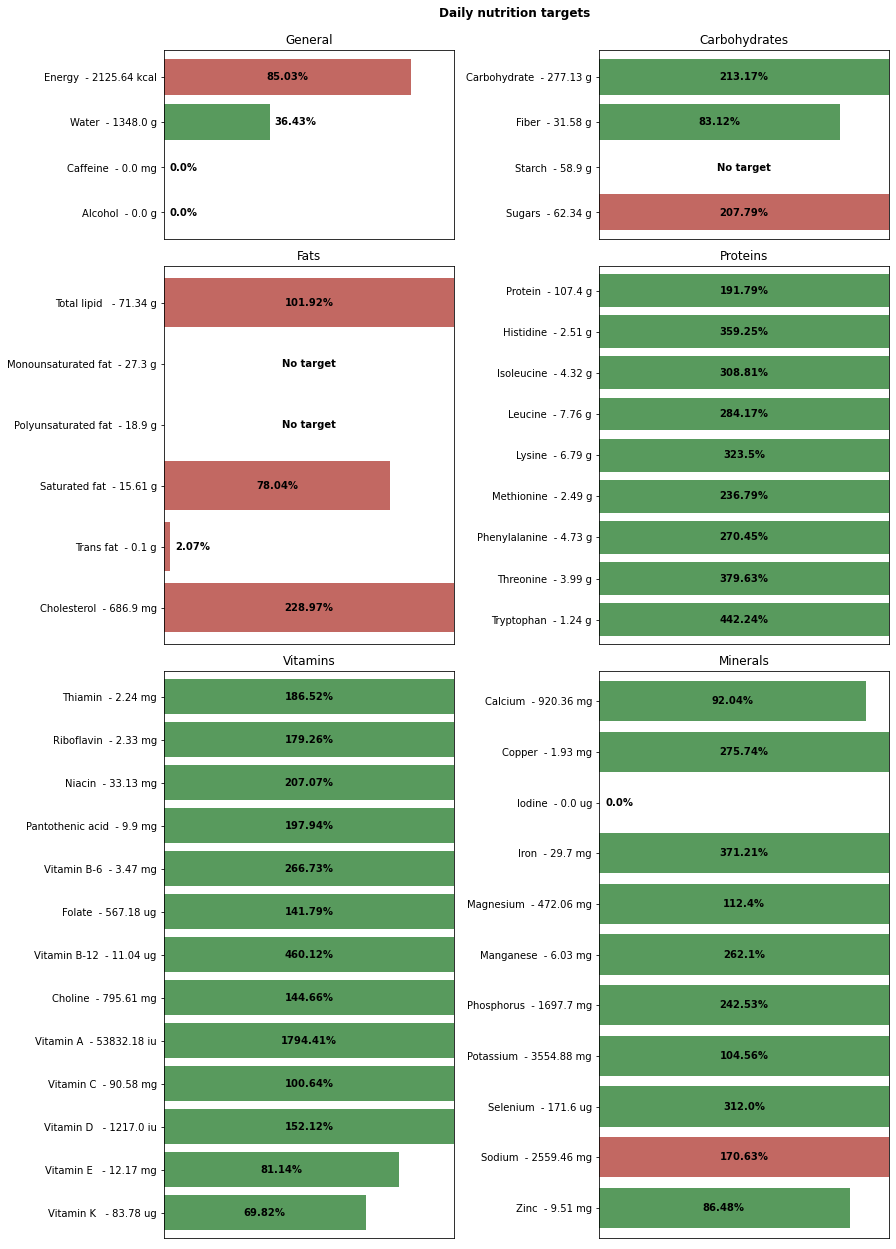

In [41]:
nutrition_vis(nutrition_diary, None, None, rdi_df, True, 'Male', 70)